In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import os
import glob as glob
from zipfile import ZipFile
from urllib.request import urlretrieve

import warnings
import logging
import absl
warnings.filterwarnings('ignore', module='absl')
absl_logger = logging.getLogger('absl')
absl_logger.setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 1. Download Sample Images

In [2]:
def download_and_unzip(url, save_path):

    # downloading zip file using urllib package
    urlretrieve(url, save_path)

    # extracting zip file using the zipfile package
    with ZipFile(save_path) as z:

        # extract ZIP file contents in the same directory
        z.extractall(os.path.split(save_path)[0])

In [3]:
URL = r'https://www.dropbox.com/s/wad5js22fbeo1be/camvid_images.zip?dl=1'

curr_dir = os.getcwd()
save_path = os.path.join(curr_dir, 'camvid_images.zip')

download_and_unzip(URL, save_path)

In [4]:
image_paths = sorted(glob.glob('camvid_images' + os.sep + '*.png'))

print('number of images:', len(image_paths))

number of images: 4


## 1.1 Display Sample Images

In [5]:
def load_image(path):
  image = cv2.imread(path)

  'convert image in BGR format to RGB'
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  'add a batch dimension which is required by the model'
  image = np.expand_dims(image, axis=0) / 255

  return image

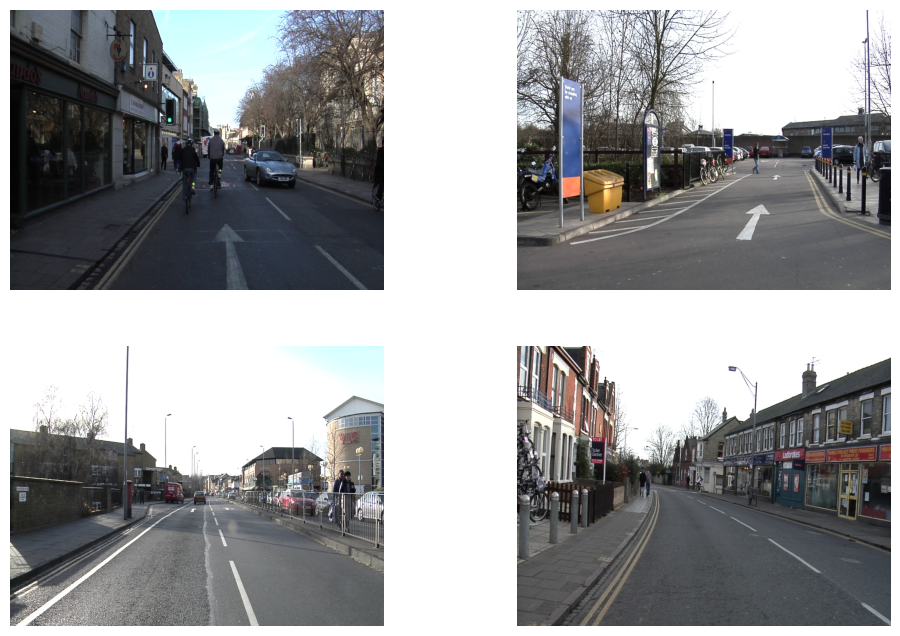

In [6]:
# store the image array of each image
image_arr = []

# plot
plt.figure(figsize=(12, 8))
for i, image_path in enumerate(image_paths):
  ax = plt.subplot(2, 2, i + 1)
  image = load_image(image_path)
  image_arr.append(image)
  plt.imshow(image[0])
  plt.axis('off');

## 1.2 Load `class_dict.csv`

`class_dict.csv` stores all 32 classes in the [CamVid](https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) dataset with their associated class IDs and RGB color labels. We will map it into a dictionary in a format of `{class: [(r, g, b), class name]}`.

In [7]:
filepath = os.path.join(curr_dir, 'class_dict.csv')
df = pd.read_csv(filepath)

df.head(5)

name    r    g    b
0     Animal   64  128   64
1    Archway  192    0  128
2  Bicyclist    0  128  192
3     Bridge    0  128   64
4   Building  128    0    0

In [8]:
class_ids = df.index.tolist()
class_names = df['name'].tolist()
rgb = df[['r', 'g', 'b']].values.tolist()

class_index = {i: [tuple(rgb[i]), class_names[i]] for i in class_ids}

In [9]:
class_index

{0: [(64, 128, 64), 'Animal'],
 1: [(192, 0, 128), 'Archway'],
 2: [(0, 128, 192), 'Bicyclist'],
 3: [(0, 128, 64), 'Bridge'],
 4: [(128, 0, 0), 'Building'],
 5: [(64, 0, 128), 'Car'],
 6: [(64, 0, 192), 'CartLuggagePram'],
 7: [(192, 128, 64), 'Child'],
 8: [(192, 192, 128), 'Column_Pole'],
 9: [(64, 64, 128), 'Fence'],
 10: [(128, 0, 192), 'LaneMkgsDriv'],
 11: [(192, 0, 64), 'LaneMkgsNonDriv'],
 12: [(128, 128, 64), 'Misc_Text'],
 13: [(192, 0, 192), 'MotorcycleScooter'],
 14: [(128, 64, 64), 'OtherMoving'],
 15: [(64, 192, 128), 'ParkingBlock'],
 16: [(64, 64, 0), 'Pedestrian'],
 17: [(128, 64, 128), 'Road'],
 18: [(128, 128, 192), 'RoadShoulder'],
 19: [(0, 0, 192), 'Sidewalk'],
 20: [(192, 128, 128), 'SignSymbol'],
 21: [(128, 128, 128), 'Sky'],
 22: [(64, 128, 192), 'SUVPickupTruck'],
 23: [(0, 0, 64), 'TrafficCone'],
 24: [(0, 64, 64), 'TrafficLight'],
 25: [(192, 64, 128), 'Train'],
 26: [(128, 128, 0), 'Tree'],
 27: [(192, 128, 192), 'Truck_Bus'],
 28: [(64, 0, 64), 'Tunnel']

# 2. Model

We will use the High-Resolution Network (HRNet) segmentation model trained on CamVid (`camvid-hrnetv2-w48`). The model has been pre-trained on the Imagenet ILSVRC-2012 classification task and fine-tuned on CamVid.

## 2.1 Load the Model from TensorFlow Hub

In [10]:
model_url = 'https://tfhub.dev/google/HRNet/camvid-hrnetv2-w48/1'
seg_model = hub.load(model_url)

## 2.2 Perform Inference

In [11]:
# make a prediction on the first image
pred_mask = seg_model.predict(image_arr[0])
print('shape of predicted mask:', pred_mask.shape)

shape of predicted mask: (1, 720, 960, 33)


## 2.3 Post-Process the Predicted Segmentation Mask

The predicted segmentation mask returned by the model contains a separate channel for each class. Each channel contains the probability that a given pixel from the input image is associated with the class for that channel. This data, therefore, requires some post-processing to obtain meaningful results. Several steps need to be performed to arrive at a final visual representation.

1. Remove the batch dimension and the background class.
2. Assign a class label to every pixel in the image based on the highest probability score across all channels.
3. The previous step results in a single-channel image that contains the class labels for each pixel. We, therefore, need to map those class IDs to RGB values so we can visualize the results as a color-coded segmentation map.

### 2.3.1 Remove the Batch Dimension and the Background Class

In [12]:
# convert tensor to numpy array
pred_mask = pred_mask.numpy()

# the 1st label is the background class added by the model, but we can remove it for this dataset
pred_mask = pred_mask[:, :, :, 1:]

# we also need to remove the batch dimension
pred_mask = np.squeeze(pred_mask)

print('Shape of predicted mask after removal of batch dimension and background class:', pred_mask.shape)

Shape of predicted mask after removal of batch dimension and background class: (720, 960, 32)


Visualize the Intermediate Results

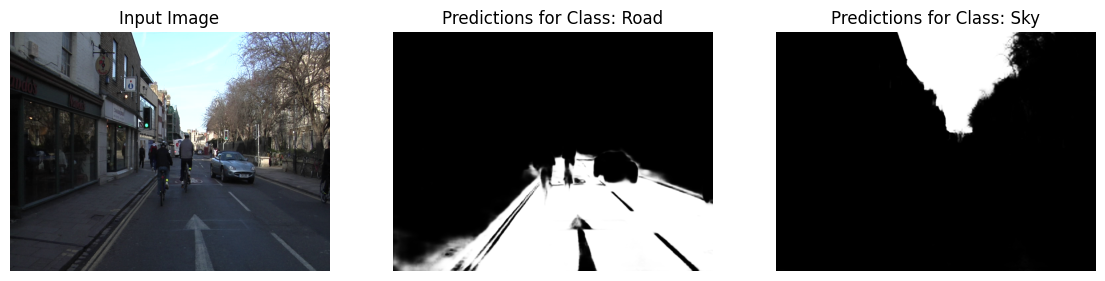

In [13]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.imshow(np.squeeze(image_arr[0]))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Predictions for Class: {}'.format(class_index[17][1]))
plt.imshow(pred_mask[:, :, 17], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predictions for Class: {}'.format(class_index[21][1]))
plt.imshow(pred_mask[:, :, 21], cmap='gray')
plt.axis('off');

### 2.3.2 Assign Each Pixel a Class Label



In [14]:
pred_mask_class = np.argmax(pred_mask, axis=-1)

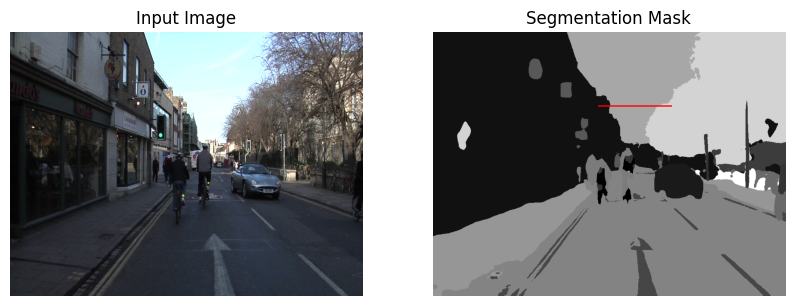

In [15]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(np.squeeze(image_arr[0]))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Segmentation Mask')
plt.imshow(pred_mask_class, cmap='gray')
plt.gca().add_patch(Rectangle((450, 200), 200, 3, edgecolor='red', facecolor='none', lw=0.5))
plt.axis('off');

### 2.3.3 Convert the Single Channel Mask to a Color Representation

In [16]:
def class_to_rgb(mask_class, class_index):

  # create RGB channels
  r_map = np.zeros_like(mask_class).astype(np.uint8)
  g_map = np.zeros_like(mask_class).astype(np.uint8)
  b_map = np.zeros_like(mask_class).astype(np.uint8)

  # populate RGB color channels based on the color assigned to each class
  for class_id in range(len(class_index)):
    index = mask_class == class_id
    r_map[index] = class_index[class_id][0][0]
    g_map[index] = class_index[class_id][0][1]
    b_map[index] = class_index[class_id][0][2]

  seg_map_rgb = np.stack([r_map, g_map, b_map], axis=2)
  return  seg_map_rgb

In [17]:
pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)

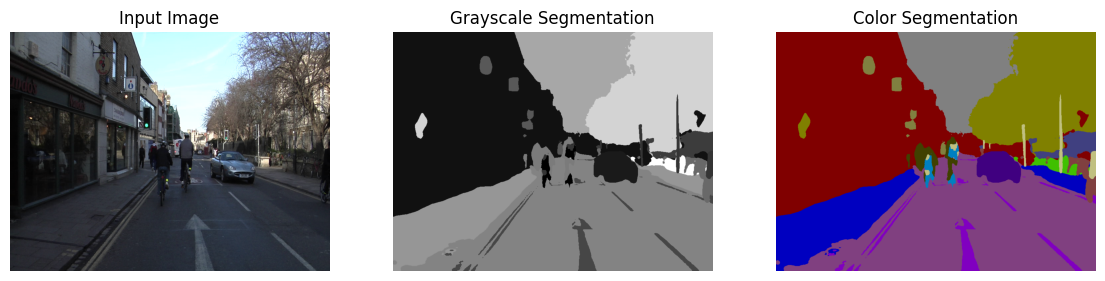

In [18]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.imshow(np.squeeze(image_arr[0]))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Grayscale Segmentation')
plt.imshow(pred_mask_class, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Color Segmentation')
plt.imshow(pred_mask_rgb, cmap='gray')
plt.axis('off');

# 3. Formalize the Implementation

We will define a function `image_overlay()` to overlay an RGB mask on top of the original image to better appreciate how the predictions line up with the original image.

In [19]:
def image_overlay(image, seg_map_rgb):

  alpha = 1    # transparency for the original image
  beta  = 0.6  # transparency for the segmentation image
  gamma = 0.0  # scalar added to each sum

  image = (image * 255).astype(np.uint8)
  seg_map_rgb = cv2.cvtColor(seg_map_rgb, cv2.COLOR_RGB2BGR)

  image = cv2.addWeighted(image, alpha, seg_map_rgb, beta, gamma)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  return image

We will define a function `run_inference()` to perform inference on several images. The function accepts a list of images and a pre-trained model. This function also handles all of the post-processing required to compute the final segmentation mask as well as the overlay.

In [20]:
def run_inference(images, model):

  for img in images:

    # forward pass through the model
    # convert the tensor output to a numpy array
    pred_mask = model.predict(img).numpy()

    # remove the background class added by the model
    pred_mask = pred_mask[:, :, :, 1:]

    # remove the batch dimension
    pred_mask = np.squeeze(pred_mask)

    # `pred_mask` is a numpy array of shape (H, W, 32) where each channel contains the probability
    # scores associated with a given class. We still need to assign a single class to each pixel
    # which is accomplished using the argmax function across the last dimension to obtain the class labels
    pred_mask_class = np.argmax(pred_mask, axis=-1)

    # convert the predicted class segmentation map to a color segmentation map
    pred_mask_rgb = class_to_rgb(pred_mask_class, class_index)

    # get the image that overlays an RGB mask on top of the original image
    overlayed_image = image_overlay(img[0], pred_mask_rgb)

    fig = plt.figure(figsize=(20, 15))

    # display the original image
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(img[0])
    ax1.title.set_text('Input Image')
    plt.axis('off')

    # display the predicted color segmentation mask
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(pred_mask_rgb)
    ax2.title.set_text('Predicted Mask')
    plt.axis('off')

    # display the predicted color segmentation mask overlayed on the original image
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(overlayed_image)
    ax3.title.set_text('Overlayed Image')
    plt.axis('off')

The function `plot_color_legend()` creates a color legend for the CamVid dataset, which is helpful for confirming the class assignments by the model.

In [21]:
def plot_color_legend(class_index):

  # extract colors and labels from class_index dictionary
  color_array = np.array([[v[0][0], v[0][1], v[0][2]] for v in class_index.values()]).astype(np.uint8)
  class_labels = [val[1] for val in class_index.values()]

  fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(14, 6))
  plt.subplots_adjust(wspace=0.5, hspace=0.01)

  # Display color legend.
  for i, axis in enumerate(ax.flat):
    axis.imshow(color_array[i][None, None, :])
    axis.set_title(class_labels[i], fontsize=8)
    axis.axis('off')

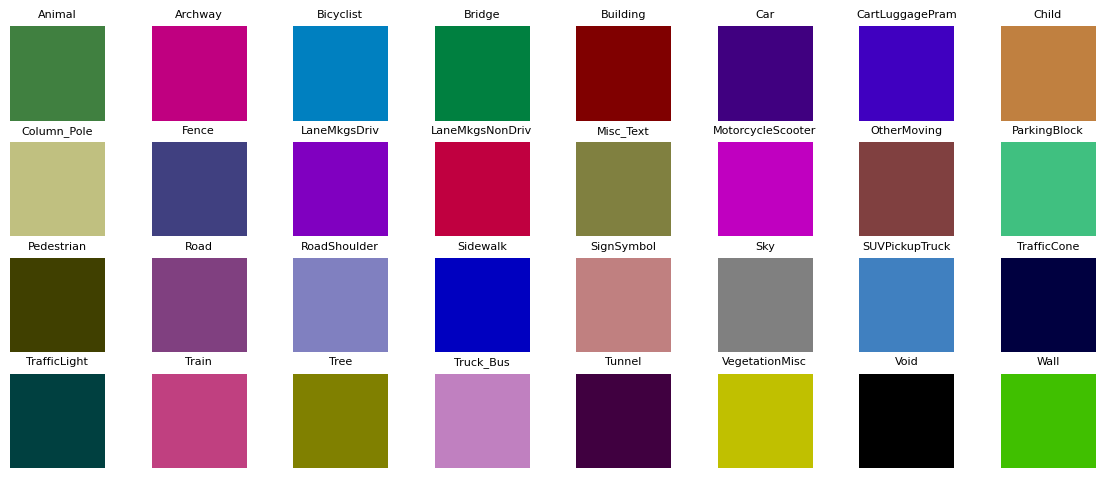

In [23]:
plot_color_legend(class_index)

## 3.1 Make Predictions on the Sample Images

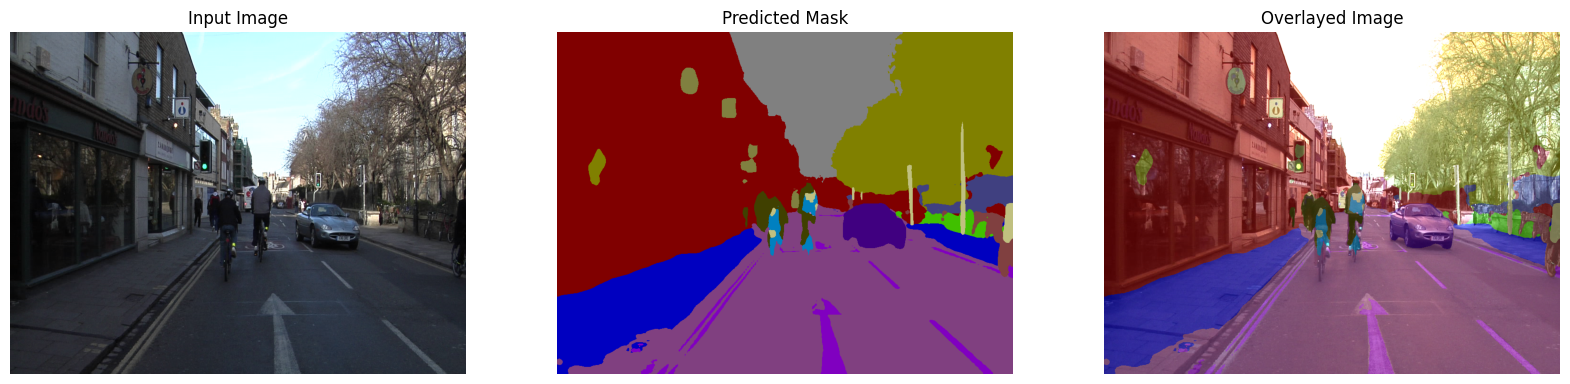

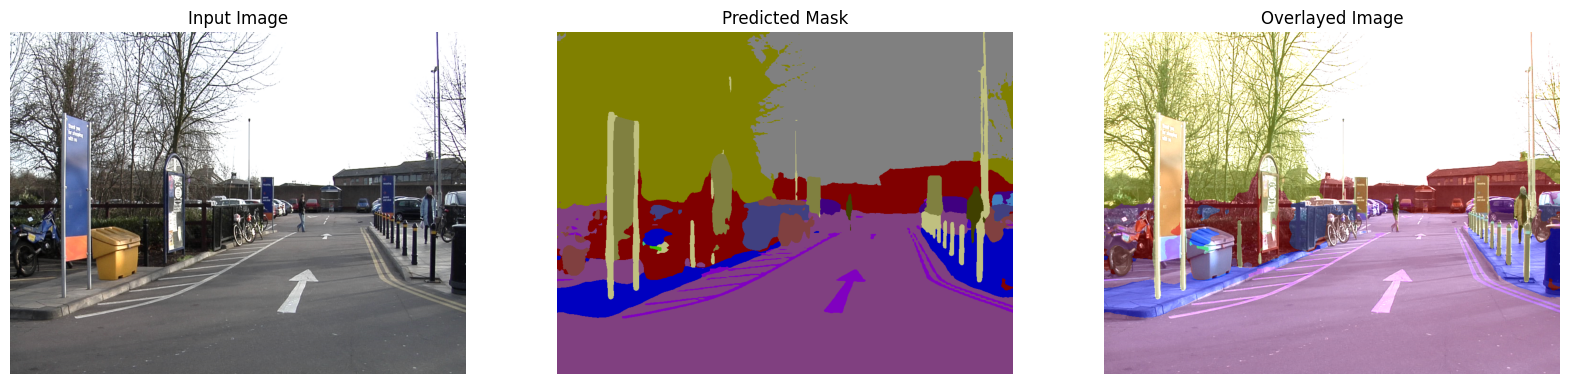

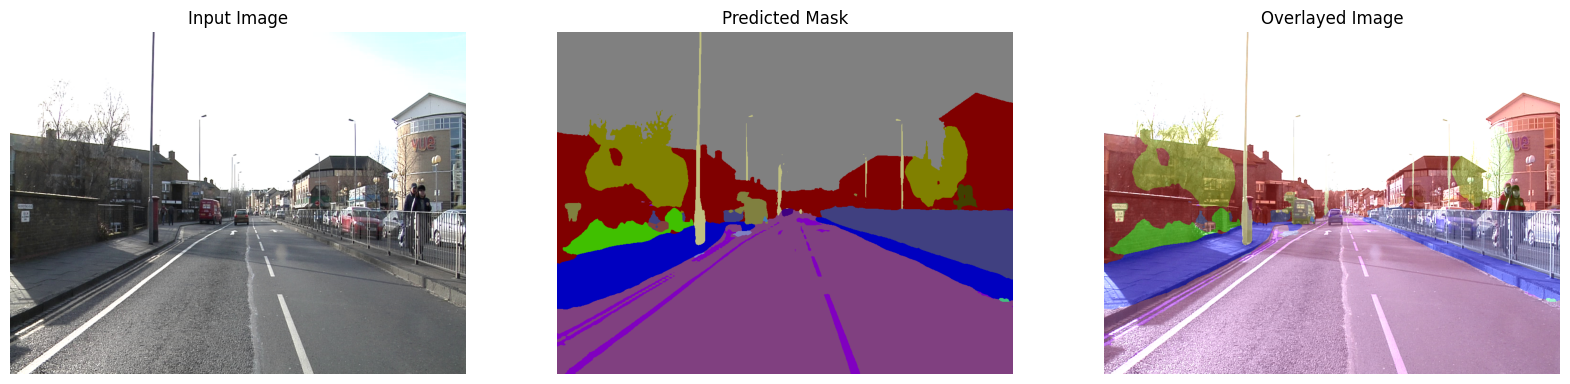

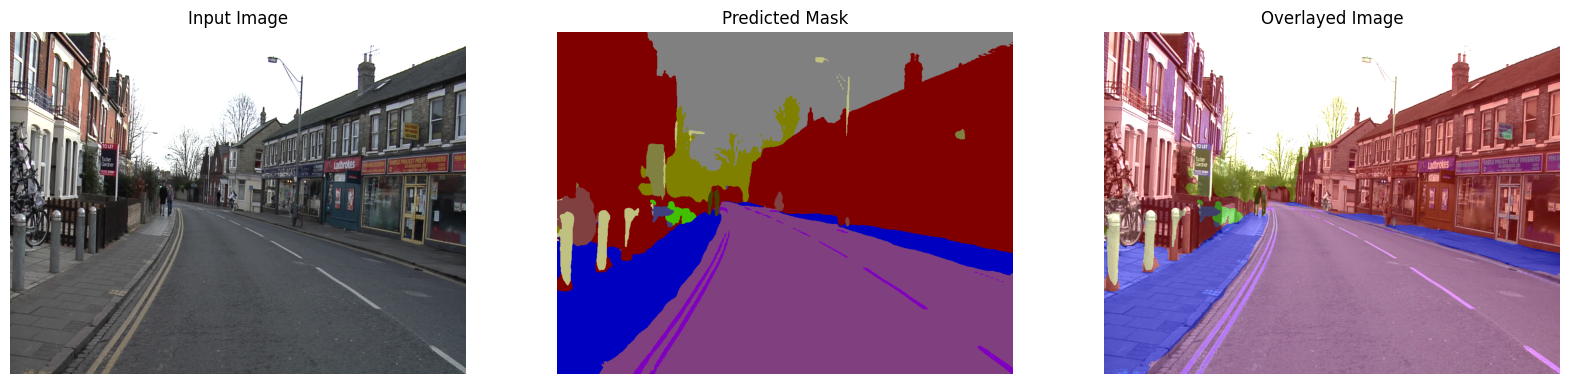

In [22]:
run_inference(image_arr, seg_model)